# Modification of the original code
I just took the code of the winner of the RSNA 2022 cervical spine fracture detection competition.  
Link: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage1

# 1st Place Solution Training 3D Semantic Segmentation (Stage1)

Hi all,

I'm very exciting to writing this notebook and the summary of our solution here.

This is FULL version of training my final models (stage1), using resnet18d as backbone, unet as decoder and using 128x128x128 as input.

NOTE: **You need to run this code locally because the RAM is not enough here.**

NOTE2: **It is highly recommended to pre-process the 3D semantic segmentation training data first and save it locally, which can greatly speed up the loading of the data.**

My brief summary of winning solution: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/362607

* Train Stage1 Notebook: This notebook
* Train Stage2 (Type1) Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage2-type1
* Train Stage2 (Type2) Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage2-type2
* Inference Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-inference

**If you find these notebooks helpful please upvote. Thanks! **

In [ ]:
#!pip -q install monai
#!pip -q install segmentation-models-pytorch==0.2.1

In [ ]:
DEBUG = False

import os
import sys
#sys.path = [
#    '../input/covn3d-same',
#] + sys.path

In [ ]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import pydicom
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import gzip
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from monai.transforms import Resize
import  monai.transforms as transforms

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

sys.path.append('./lib_models')

# Config

In [ ]:
RESOL = 128

BASE_PATH = '/home/junseonglee/01_codes/input/rsna-2023-abdominal-trauma-detection'
MASK_SAVE_PATH = f'{BASE_PATH}/mask_preprocessed'
MASK_VALID_PATH = f'{BASE_PATH}/mask_validation'

kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_blocks = 4
n_folds = 5
backbone = 'resnet18d'

image_sizes = [128, 128, 128]
R = Resize(image_sizes)

init_lr = 3e-3
batch_size = 4
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1

data_dir = '../input/rsna-2022-cervical-spine-fracture-detection'
use_amp = True
num_workers = 8
out_dim = 5

n_epochs = 1000

log_dir = f'{BASE_PATH}/seg_models_backup'
model_dir = f'{BASE_PATH}/seg_models_backup'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
os.makedirs(MASK_VALID_PATH, exist_ok=True)

In [ ]:
transforms_valid = transforms.Compose([
])

# DataFrame

In [ ]:
df_seg = pd.read_csv(f'{BASE_PATH}/seg_info.csv')

kf = KFold(5, shuffle = True, random_state = 0)
df_seg['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_seg, df_seg)):
    df_seg.loc[valid_idx, 'fold'] = fold

df_seg.tail()

# Dataset

In [ ]:
revert_list = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
]

In [ ]:
def compress(name, data):
    with gzip.open(name, 'wb') as f:
        pickle.dump(data, f)

def decompress(name):
    with gzip.open(name, 'rb') as f:
        data = pickle.load(f)
    return data

def load_pickle(name):
    with open(name, 'rb') as f:
        data = pickle.load(f)
    return data    

def load_sample(row, has_mask=True):
    image = decompress(row['img_path'])[None]

    if has_mask:
        mask = load_pickle(row['mask_path'])
        
        return image, mask
    else:
        return image



class SEGDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        
        ### using local cache
#         image_file = os.path.join(data_dir, f'{row.StudyInstanceUID}.npy')
#         mask_file = os.path.join(data_dir, f'{row.StudyInstanceUID}_mask.npy')
#         image = np.load(image_file).astype(np.float32)
#         mask = np.load(mask_file).astype(np.float32)

        image, mask = load_sample(row, has_mask=True)
        image = torch.from_numpy(image).to(torch.float32)
        mask  = torch.from_numpy(mask).to(torch.float32)

        res = self.transform({'image':image, 'mask':mask})
        image = res['image']
        mask = res['mask']


        return image, mask


In [ ]:
rcParams['figure.figsize'] = 20,8

df_show = df_seg

# Model

In [ ]:
class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=1,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 1, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

In [ ]:
from timm.models.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output


m = TimmSegModel(backbone)
m = convert_3d(m)
m(torch.rand(1, 1, 128,128,128)).shape

In [ ]:
from typing import Any, Dict, Optional


def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    threshold: Optional[float] = None,
    nan_score_on_empty=False,
    eps: float = 1e-7,
) -> float:

    if threshold is not None:
        y_pred = (y_pred > threshold).to(y_true.dtype)

    intersection = torch.sum(y_pred * y_true).item()
    cardinality = (torch.sum(y_pred) + torch.sum(y_true)).item()

    score = (2.0 * intersection) / (cardinality + eps)

    has_targets = torch.sum(y_true) > 0
    has_predicted = torch.sum(y_pred) > 0

    if not has_targets:
        if nan_score_on_empty:
            score = np.nan
        else:
            score = float(not has_predicted)
    return score


def multilabel_dice_score(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    threshold=None,
    eps=1e-7,
    nan_score_on_empty=False,
):
    ious = []
    num_classes = y_pred.size(0)
    for class_index in range(num_classes):
        iou = binary_dice_score(
            y_pred=y_pred[class_index],
            y_true=y_true[class_index],
            threshold=threshold,
            nan_score_on_empty=nan_score_on_empty,
            eps=eps,
        )
        ious.append(iou)

    return ious


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=loss_weights):
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = bce_dice

# Valid func

In [ ]:
def test_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    ths = [0.1]
    batch_metrics = [[]]
    bar = tqdm(loader_valid)

    counter = 0
    
    with torch.no_grad():
        for images, gt_masks in bar:
            images = images.cuda()
            gt_masks = gt_masks.cuda()

            logits = model(images)
            images = images.cpu().numpy()
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for thi, th in enumerate(ths):
                pred = (logits.sigmoid() > th).float().detach()
                for i in range(logits.shape[0]):
                    image = images[i]
                    y_pred = logits[i].sigmoid().cpu()
                    y_true = gt_masks[i].cpu()
                    tmp = multilabel_dice_score(
                        y_pred=y_pred,
                        y_true=y_true,
                        threshold=0.5,
                    )
                    y_pred = y_pred.numpy()
                    y_true = y_true.numpy()
                    compress(f'{MASK_VALID_PATH}/image_{counter}.pkl', image)                    
                    compress(f'{MASK_VALID_PATH}/pred_{counter}.pkl', y_pred)
                    compress(f'{MASK_VALID_PATH}/true_{counter}.pkl', y_true)
                    counter +=1
                    batch_metrics[thi].extend(tmp)
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
            
    metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    print('best th:', ths[np.argmax(metrics)], 'best dc:', np.max(metrics))
    best_th = ths[np.argmax(metrics)]
    

    return np.mean(valid_loss), np.max(metrics)


In [ ]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
lrs = []
for epoch in range(1, 1000+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

# Training

In [ ]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)

    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)

    model.load_state_dict(torch.load(model_file))
    model = model.to(device)
    
    from_epoch = 0

    print(len(dataset_valid))

    valid_loss, metric = test_func(model, loader_valid)

    del model
    torch.cuda.empty_cache()
    gc.collect()


In [ ]:
run(0)

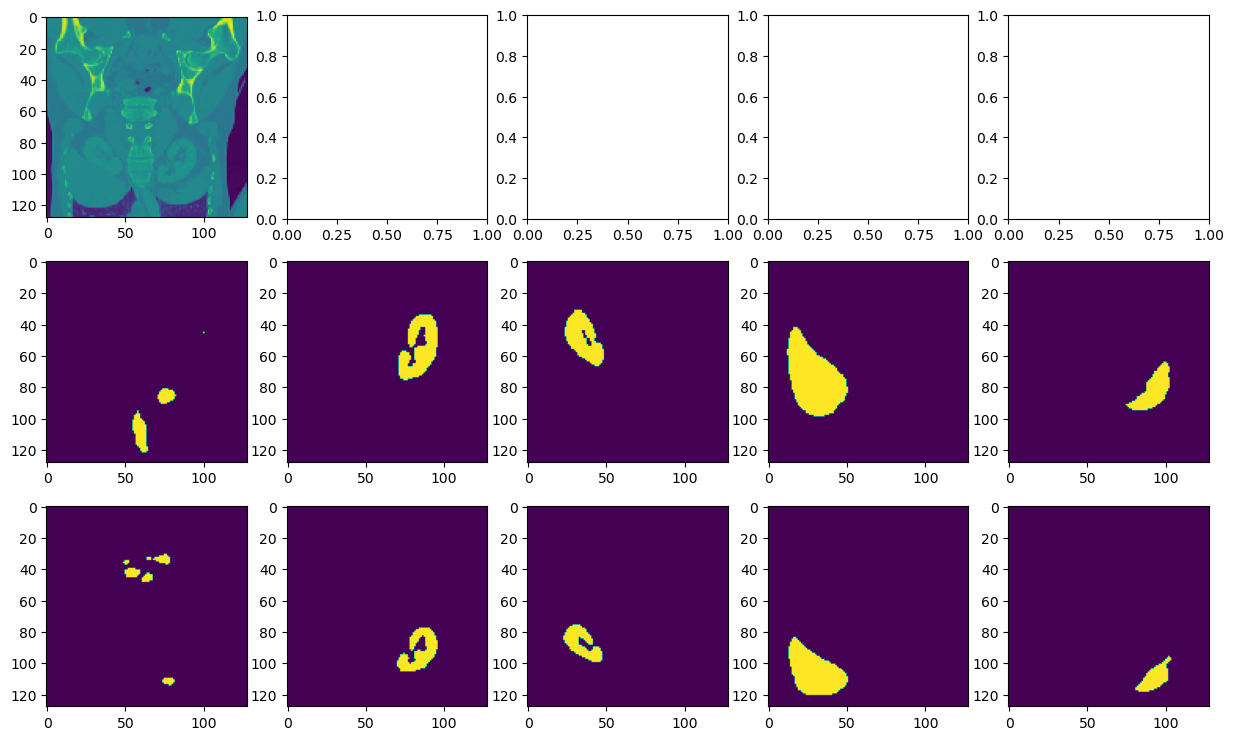

In [29]:
for i in range(0, 40):
    if (i!=4):
        continue
    origin_img = decompress(f'{MASK_VALID_PATH}/image_{i}.pkl')
    true_img = decompress(f'{MASK_VALID_PATH}/true_{i}.pkl')
    pred_img = decompress(f'{MASK_VALID_PATH}/pred_{i}.pkl')

    f, axs = plt.subplots(3, 5, figsize=(15, 9))
    try:
        pred_img += 0.1
    except:
        asdf = 0
    pred_img = pred_img.astype(np.uint8)
    axs[0,0].imshow(origin_img[0,:,80,:])  
    for j in range(0, 5):              
        axs[1,j].imshow(true_img[j,:,80,:])
        axs[2,j].imshow(pred_img[j,:,80,:])
    del true_img, pred_img
    gc.collect()
